Processing...
Done!


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: 0it [00:00, ?it/s]

Epoch 2: 0it [00:00, ?it/s]

Epoch 3: 0it [00:00, ?it/s]

Epoch 4: 0it [00:00, ?it/s]

Epoch 5: 0it [00:00, ?it/s]

Epoch 6: 0it [00:00, ?it/s]

Epoch 7: 0it [00:00, ?it/s]

Epoch 8: 0it [00:00, ?it/s]

Epoch 9: 0it [00:00, ?it/s]

Epoch 10: 0it [00:00, ?it/s]

Epoch 11: 0it [00:00, ?it/s]

Epoch 12: 0it [00:00, ?it/s]

Epoch 13: 0it [00:00, ?it/s]

Epoch 14: 0it [00:00, ?it/s]

Epoch 15: 0it [00:00, ?it/s]

Epoch 16: 0it [00:00, ?it/s]

Epoch 17: 0it [00:00, ?it/s]

Epoch 18: 0it [00:00, ?it/s]

Epoch 19: 0it [00:00, ?it/s]

Epoch 20: 0it [00:00, ?it/s]

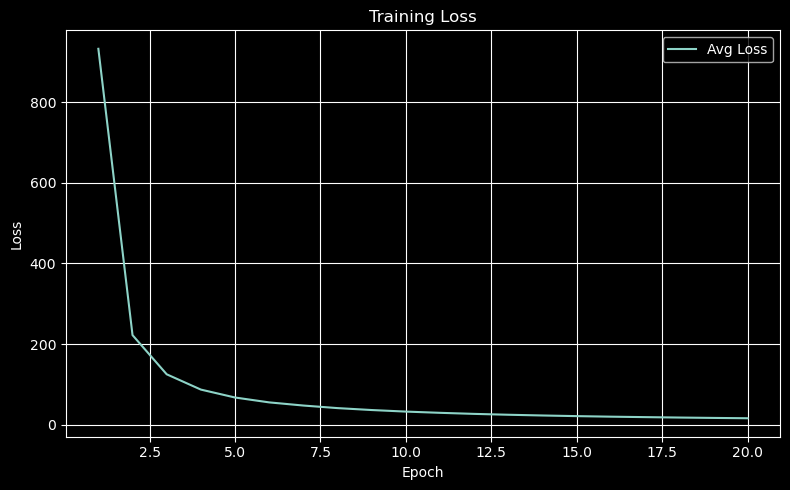

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import EllipticBitcoinDataset
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_dense_adj
from pygod.nn import DOMINANTBase  # need DOMINANTBase because DOMINANT doesn't like mini-batching
from tqdm.notebook import tqdm  #  

# Load data
dataset = EllipticBitcoinDataset(root='data/elliptic', force_reload=True)

data = dataset[0] # Need to index in because  team-pyg couldnt figure out a less dumb way to load the dataset

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader = NeighborLoader(data, batch_size=2048, shuffle=True, num_neighbors=[10, 10], input_nodes=data.train_mask) # I think this ithe right way. Should investigate the math. 
model = DOMINANTBase(in_dim=data.num_node_features).to(device) # I didn't do any tuning. 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # I didn't do any tuning. 
num_epochs = 20
loss_history = []

# Training loop
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    total_loss = 0

    for i, batch in tqdm(enumerate(loader), desc=f"Epoch {epoch+1}", leave=True):
        batch = batch.to(device)
        x = batch.x
        edge_index = batch.edge_index
        batch_size = getattr(batch, 'batch_size', x.size(0))

        optimizer.zero_grad()
        x_hat, s_hat = model(x, edge_index)
        s = to_dense_adj(edge_index)[0].to(device)

        loss_matrix = model.loss_func(x[:batch_size], x_hat[:batch_size], 
                                      s[:batch_size, :], s_hat[:batch_size]) # Need to learn the math. 
        
        loss = torch.mean(loss_matrix) # batchwise mean for calculating the gradient

        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # but it gets summed for record keeping
        

    avg_loss = total_loss / i # and then divided so that it's reflective of the full graph
    loss_history.append(avg_loss)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(loss_history)+1), loss_history, label='Avg Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()